# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
# What are we working with?
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:
# What is missing before preprocessing?
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [11]:
# what types of values are we converting to nan?
feat_info['missing_or_unknown'].unique()
# These will convert to strings of ints but not strings of floats. 

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [12]:
# Identify missing or unknown data values and convert them to NaNs.

# convert Nans into -100 & append -100 to list of missing and unknowns
# turn all float columns into int
for index, row in feat_info.iterrows():
    missing_or_unknowns = row['missing_or_unknown'].strip('[]').split(',')
    if azdias[row['attribute']].dtype.name == 'float64':
        missing_or_unknowns.append('-100')
        azdias[row['attribute']] = azdias[row['attribute']].fillna(-100).astype(np.int64)
        azdias[row['attribute']] = azdias[row['attribute']].map(lambda d: np.nan if str(d) in missing_or_unknowns else d)
    else:
        azdias[row['attribute']] = azdias[row['attribute']].map(lambda d: np.nan if str(d) in missing_or_unknowns else d)

In [13]:
# did it work?
for index, row in feat_info.iterrows():
    missing_or_unknowns = row['missing_or_unknown'].strip('[]').split(',')
    features_data = []
    for u in list(azdias[row['attribute']].unique()):
        try:
            features_data.append(str(int(u)))
        except:
            features_data.append(str(u))
#     print(row['attribute'], missing_or_unknowns, features_data) # there are no -100 remaining
    if bool(set(missing_or_unknowns) & set(features_data)):
        print(row['attribute']) # nothing printed. YES!

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_in_each_column = azdias.isnull().sum()
missing_in_each_column.describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [15]:
pd.Series(missing_in_each_column.sort_values()/azdias.shape[0]).describe()

count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64

In [16]:
missing_in_each_column.sort_values(ascending=False)/azdias.shape[0]

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [17]:
missing_in_each_column.sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

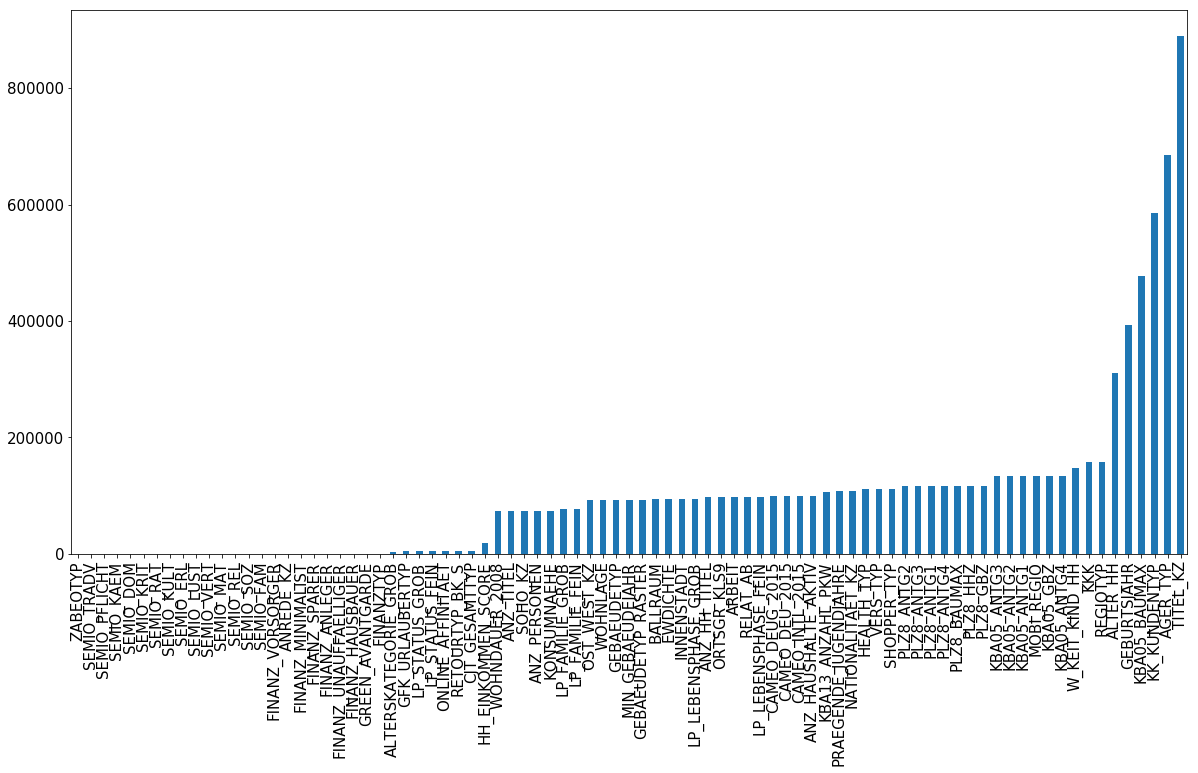

In [18]:
# Investigate patterns in the amount of missing data in each column.
missing_in_each_column.sort_values().plot(kind='bar', figsize=(20,10), fontsize=15)

In [19]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
column_threshold = missing_in_each_column.mean()+missing_in_each_column.std()
azdias = azdias.loc[:, azdias.isnull().sum() <= column_threshold]
print(azdias.shape)

(891221, 79)


In [20]:
# columns we removed
list(missing_in_each_column[missing_in_each_column > column_threshold].index)

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

#### Discussion 1.1.2: Assess Missing Data in Each Column
##### Are there any patterns in missing values? 
On average, each column is is missing 98,516 values, roughly 11% of its data. 68% of the columns are showing a deviation of 146,604 missing values more or less than the mean. The fact that the standard deviation is larger than the mean indicates the presense of outlier columns missing a great number of values. 75% of the columns are missing 116515 values and less.

##### Which columns were removed from the dataset?
Based on the pattern described above, I have decided that columns missing more than 1 standard deviation from the mean will be outliers. The visualization above shows 6 columns are missing significantly more values than the other columns, 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'. These six columns are missing more than 300,000 values, well over 1 standard deviation from the average number of missing values per column. With more than a third of its data missing, I believe it would be more prudent to remove these columsn as features rather than filling in that many missing values and possibly influencing the model with ficticious data. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [21]:
# How much data is missing in each row of the dataset?
missing_in_each_row = azdias.isnull().sum(axis=1)
missing_in_each_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

Text(0,0.5,'Number of Rows with Missing Data')

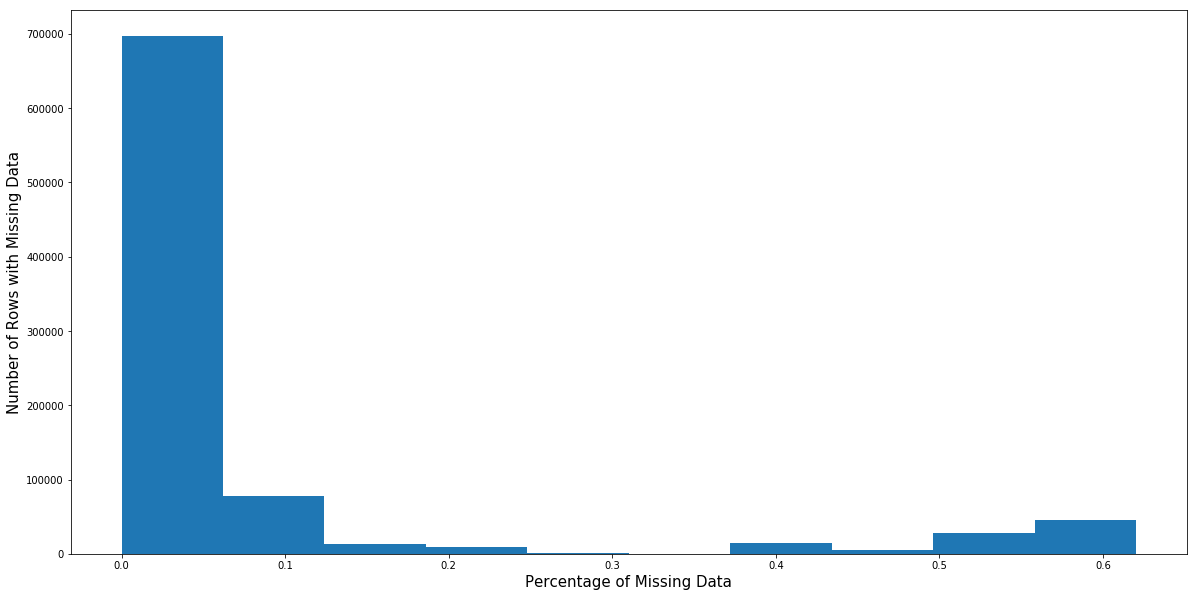

In [22]:
(missing_in_each_row/azdias.shape[1]).plot(kind='hist', bins=10, figsize=(20,10))
plt.xlabel('Percentage of Missing Data', fontsize=15)
plt.ylabel('Number of Rows with Missing Data', fontsize=15)

Text(0,0.5,'Number of Rows with Missing Data')

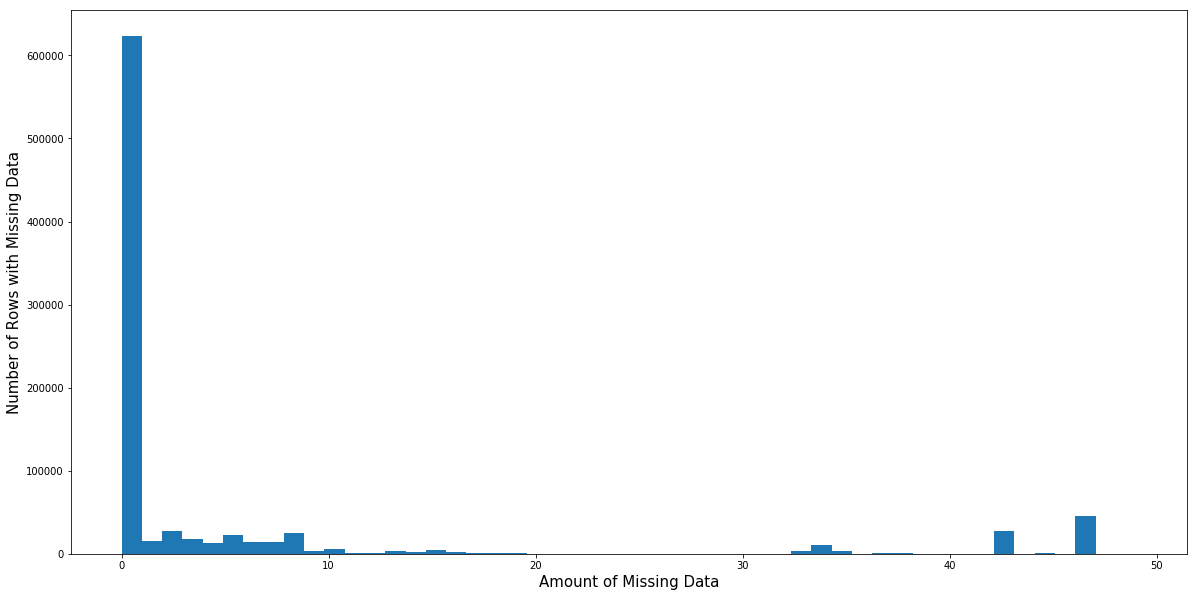

In [23]:
missing_in_each_row.plot(kind='hist', bins=50, figsize=(20,10))
plt.xlabel('Amount of Missing Data', fontsize=15)
plt.ylabel('Number of Rows with Missing Data', fontsize=15)

In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
row_threshold = missing_in_each_row.mean()+missing_in_each_row.std()
print(row_threshold)
threshold_over = azdias.loc[azdias.isnull().sum(axis=1)>= row_threshold]
under_threshold = azdias.loc[azdias.isnull().sum(axis=1)< row_threshold]
print(threshold_over.shape)
print(under_threshold.shape)

18.8845803356
(95324, 79)
(795897, 79)


In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

sample_columns = azdias.loc[:, azdias.isnull().sum()==0].sample(5, axis=1).columns
print(sample_columns)

Index(['SEMIO_VERT', 'SEMIO_RAT', 'FINANZ_VORSORGER', 'SEMIO_KAEM',
       'SEMIO_PFLICHT'],
      dtype='object')


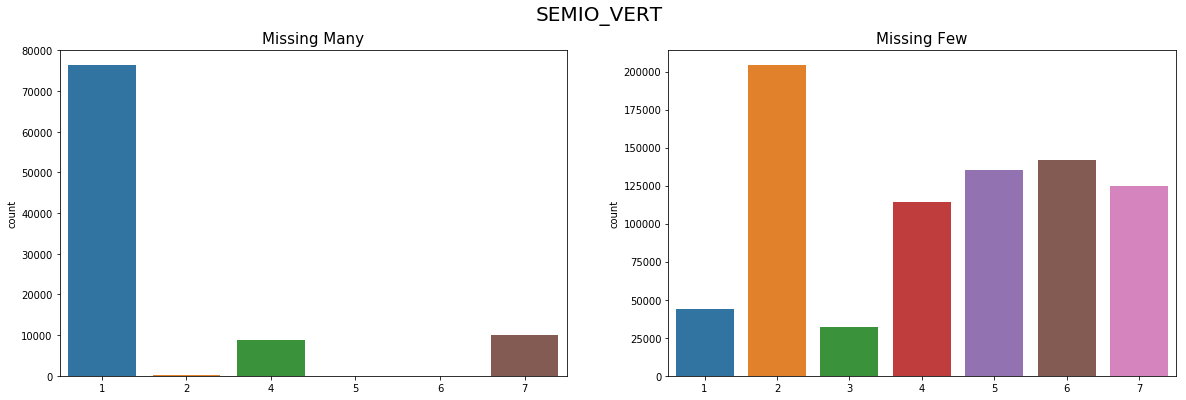

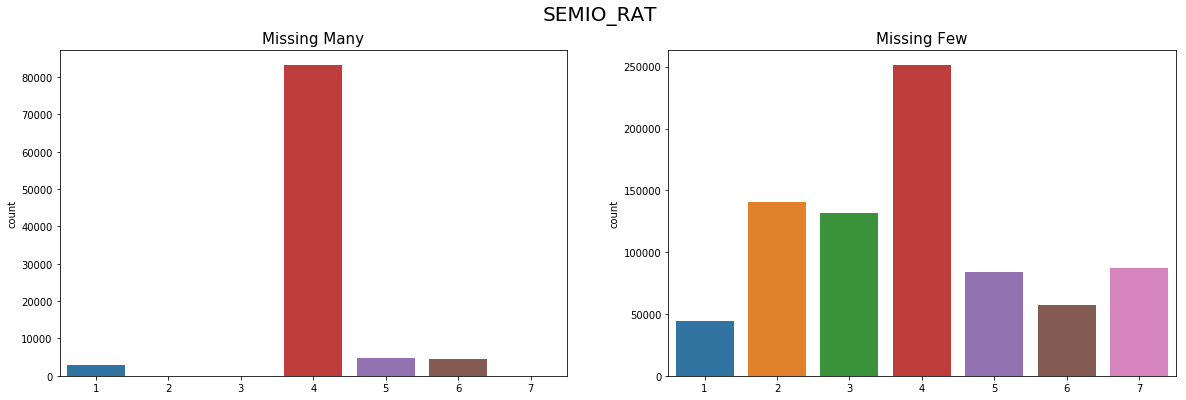

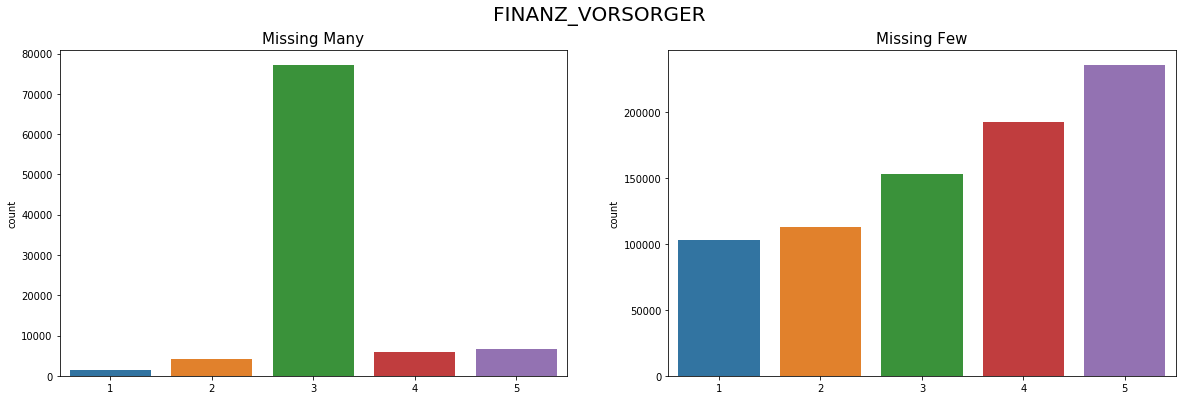

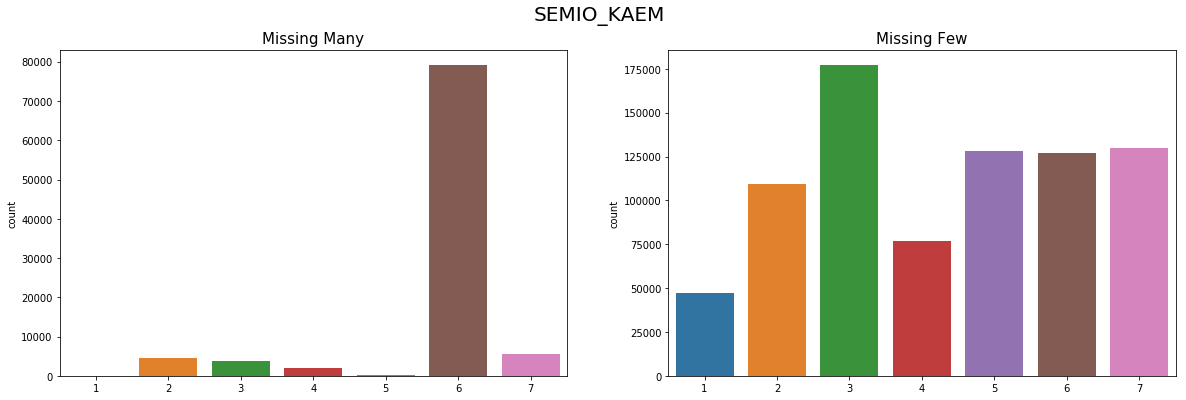

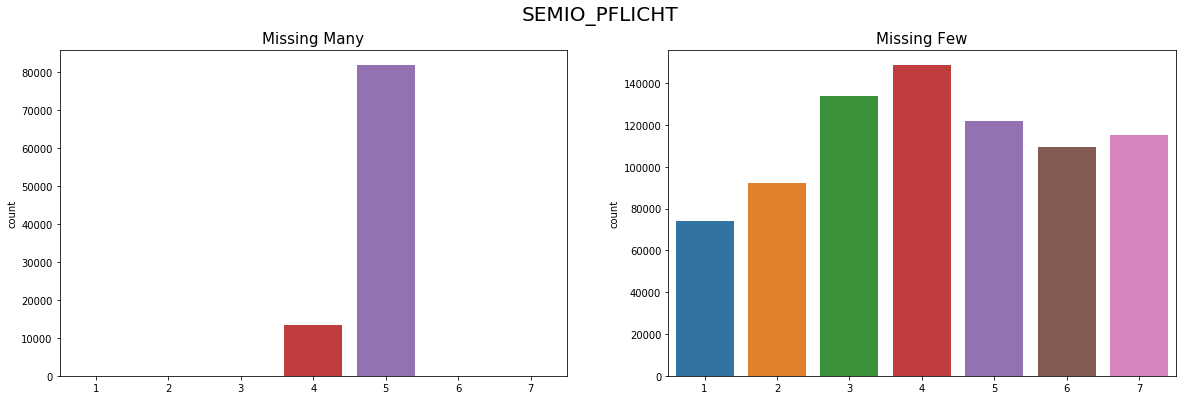

In [26]:
for i, col in enumerate(sample_columns):
    plt.figure(i, figsize=(20,6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(threshold_over[col].values)
    plt.title('Missing Many', fontsize=15)
    
    plt.subplot(1, 2, 2)
    sns.countplot(under_threshold[col].values) 
    plt.title('Missing Few', fontsize=15)
    
    plt.suptitle(col, fontsize=20)

#### Discussion 1.1.3: Assess Missing Data in Each Row
##### My observations regarding missing data in rows.
On average, each row is missing 5.65 values. 68% of the rows are showing a deviation of about 13.23 missing values more or less than the mean. The fact that the standard deviation is greater than the mean indicates that there are outliers missing a large number of values.  75% of the rows are missing 3 values or less. At least one row is missing 49 values out of 79 features. Based on this pattern, I have decided to set the threshold for missing data per row at 1 standard deviation above the mean nubmer of missing data per row, at about 19 missing values. 

##### Are the data with lots of missing values qualitatively different from data with few or no missing values?
I split the dataset into 2 subsets, one set missing more than the threshold of 19 missing values, and one set missing less than the threshold. A visualization of 5 random features, 'SEMIO_VERT', 'SEMIO_RAT', 'FINANZ_VORSORGER', 'SEMIO_KAEM', and 'SEMIO_PFLICHT', show that there is a qualitative difference between the 2 subsets, across all 5 features. The subset missing more than the threshold show drastic spikes in only 1 category of each feature. The subset missing less than the threshold show a comparativetly more even distribution across the categories within each feature. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_info = feat_info[feat_info['attribute'].isin(under_threshold.columns)]
feat_info['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for index, row in feat_info.iterrows():
    col = under_threshold[row['attribute']]
    feat_info.loc[index, 'unique'] = str(col.unique())
    feat_info.loc[index, 'nunique'] = int(col.dropna().nunique())
categorical_feat_info = feat_info[feat_info['type'] == 'categorical'].reset_index(drop=True)
categorical_feat_info

,attribute,information_level,type,missing_or_unknown,unique,nunique
0,ANREDE_KZ,person,categorical,"[-1,0]",[2 1],2.0
1,CJT_GESAMTTYP,person,categorical,[0],[ 5. 3. 2. 4. 1. 6. nan],6.0
2,FINANZTYP,person,categorical,[-1],[1 6 5 2 4 3],6.0
3,GFK_URLAUBERTYP,person,categorical,[],[ 10. 1. 5. 12. 9. 3. 8. 11. 4. ...,12.0
4,GREEN_AVANTGARDE,person,categorical,[],[0 1],2.0
5,LP_FAMILIE_FEIN,person,categorical,[0],[ 5. 1. nan 10. 2. 7. 11. 8. 4. ...,11.0
6,LP_FAMILIE_GROB,person,categorical,[0],[ 3. 1. nan 5. 2. 4.],5.0
7,LP_STATUS_FEIN,person,categorical,[0],[ 2. 3. 9. 4. 1. 10. 5. 8. 6. ...,10.0
8,LP_STATUS_GROB,person,categorical,[0],[ 1. 2. 4. 5. 3. nan],5.0
9,NATIONALITAET_KZ,person,categorical,"[-1,0]",[ 1. 3. 2. nan],3.0


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
re_encode = {'W': 1, 'O': 0}
under_threshold['OST_WEST_KZ'].replace(re_encode,inplace = True)
under_threshold['OST_WEST_KZ'].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [30]:
print('Before', under_threshold.shape)
under_threshold.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'], axis=1, inplace=True)
print('After', under_threshold.shape)

Before (795897, 79)
After (795897, 76)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
categorical_feat_info = categorical_feat_info[~categorical_feat_info['attribute'].isin(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'])].reset_index(drop=True)
multi_cat_cols = list(categorical_feat_info[categorical_feat_info['nunique']>2]['attribute'])
azdias_dummied = pd.get_dummies(under_threshold, columns=multi_cat_cols)

#### Discussion 1.2.1: Re-Encode Categorical Features
##### My findings and decisions regarding categorical features. 
There are 18 categorical features, of which 13 are multi-level categoricals. Most of these categoricals appear to be pertinent demographic information. However, 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', and 'CAMEO_DEUG_2015' are rough scale versions of features we already have in our dataset. 

  * 'CJT_GESAMTTYP', preferred information and buying channels for consumer
  * 'FINANZTYP', Most descriptive financial type for individual
  * 'GFK_URLAUBERTYP', Vacation habits
  * 'LP_FAMILIE_FEIN', Family type, fine scale
  * 'LP_FAMILIE_GROB', Family type, rough scale
  * 'LP_STATUS_FEIN', Social status, fine scale
  * 'LP_STATUS_GROB', Social status, rough scale
  * 'NATIONALITAET_KZ', Nationality based on given name analysis
  * 'SHOPPER_TYP', Shopper typology
  * 'ZABEOTYP', Energy consumption typology
  * 'GEBAEUDETYP', Type of building (residential vs. commercial)
  * 'CAMEO_DEUG_2015', Wealth / Life Stage Typology, rough scale
  * 'CAMEO_DEU_2015', Wealth / Life Stage Typology, detailed scale 
  
Of the 5 binary categoricals, 1 feature is non-numerical.     
  * 'OST_WEST_KZ', Building location via former East / West Germany (GDR / FRG)
  
2 of the binary categoricals use 1 and 2 to differentiate their categories rather than 0 and 1, as the remaining 2 binary categoricals. All the binary categoricals also appear to be relevant demographic information.    
  * 'ANREDE_KZ', Gender
  * 'GREEN_AVANTGARDE', Membership in environmental sustainability as part of youth
  * 'SOHO_KZ', Small office / home office flag
  * 'VERS_TYP', Insurance typology
    
I have decided to keep all the categorical features except 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', and 'CAMEO_DEUG_2015' as they contain redundant information.

##### Which ones did you keep, which did you drop, and what engineering steps did you perform?
I dropped 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', and 'CAMEO_DEUG_2015' and encoded the rest of the 10 multi-level categoricals as dummy variables. As dummy variables each category of each feature will get its own column, i.e. 1 for upper class, 0 for not upper class.   
  
I encoded the non-numerical binary categorical feature, 'OST_WEST_KZ', as numerical categories, 1 for West Germany and 0 for East Germany. I left the binary categoricals that use 2 and 1 as categories alone as StandardScaler will take care of that later.   


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [32]:
feat_info[feat_info['type'] == 'mixed'].reset_index(drop=True)

,attribute,information_level,type,missing_or_unknown,unique,nunique
0,LP_LEBENSPHASE_FEIN,person,mixed,[0],[ 21. 3. nan 32. 8. 2. 5. 10. 4. ...,40.0
1,LP_LEBENSPHASE_GROB,person,mixed,[0],[ 6. 1. nan 10. 2. 3. 5. 7. 12. ...,12.0
2,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]",[ 14. 15. 8. 3. 10. 11. 5. 9. 6. ...,15.0
3,WOHNLAGE,building,mixed,[-1],[ 4. 2. 7. 3. 5. 1. 8. 0.],8.0
4,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]",['51' '24' '12' '43' '54' '22' '14' '13' '15' ...,21.0
5,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]",[ 1. 2. nan 4. 5. 3.],5.0


In [33]:
print('Before', azdias_dummied.shape)
azdias_dummied.drop(['LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
print('After', azdias_dummied.shape)

Before (795897, 175)
After (795897, 174)


In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_dummied['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182443
8.0     141290
10.0     85622
5.0      84581
3.0      53754
15.0     42364
11.0     35647
9.0      33551
6.0      25646
12.0     24423
1.0      20610
4.0      20444
2.0       7478
13.0      5750
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [35]:
PJ_mapping = {1:(1940, 'Mainstream'), 2:(1940, 'Avantgarde'), 3:(1950, 'Mainstream')
              , 4:(1950, 'Avantgarde'), 5:(1960, 'Mainstream'), 6:(1960, 'Avantgarde')
              , 7:(1960, 'Avantgarde'), 8:(1970, 'Mainstream'), 9:(1970, 'Avantgarde')
              , 10:(1980, 'Mainstream'), 11:(1980, 'Avantgarde'), 12:(1980, 'Mainstream')
              , 13:(1980, 'Avantgarde'), 14:(1990, 'Mainstream'), 15:(1990, 'Avantgarde')}

In [36]:
movement_mapping = {key: (0 if value[-1] == 'Mainstream' else 1) \
                    for key, value in PJ_mapping.items()}
# 'Mainstream' encoded as 0
# 'Avantgarde' encoded as 1
azdias_dummied['PJ_AVANTGARDE'] = azdias_dummied['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)

In [37]:
decade_mapping = {key: value[0] for key, value in PJ_mapping.items()}
azdias_dummied['PJ_DECADE'] = azdias_dummied['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)

In [38]:
azdias_dummied[['PRAEGENDE_JUGENDJAHRE', 'PJ_AVANTGARDE', 'PJ_DECADE']].head()

,PRAEGENDE_JUGENDJAHRE,PJ_AVANTGARDE,PJ_DECADE
1,14.0,0.0,1990.0
2,15.0,1.0,1990.0
3,8.0,0.0,1970.0
4,8.0,0.0,1970.0
5,3.0,0.0,1950.0


In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_dummied['CAMEO_INTL_2015'].value_counts()

51    133656
41     92286
24     91047
14     62821
43     56630
54     45359
25     39584
22     33114
23     26608
13     26301
45     26119
55     23925
52     20536
31     18934
34     18508
15     16962
44     14813
12     13223
35     10348
32     10341
33      9923
Name: CAMEO_INTL_2015, dtype: int64

In [40]:
CI_mapping = {s:(s[0], s[-1]) for s in azdias_dummied['CAMEO_INTL_2015'].dropna().unique()}

In [41]:
wealth_mapping = {key: value[0] for key, value in CI_mapping.items()}
azdias_dummied['CI_WEALTH'] = azdias_dummied['CAMEO_INTL_2015'].replace(wealth_mapping)

life_stage_mapping = {key: value[-1] for key, value in CI_mapping.items()}
azdias_dummied['CI_LIFE_STAGE'] = azdias_dummied['CAMEO_INTL_2015'].replace(life_stage_mapping)

In [42]:
azdias_dummied[['CAMEO_INTL_2015', 'CI_WEALTH', 'CI_LIFE_STAGE']].head()

,CAMEO_INTL_2015,CI_WEALTH,CI_LIFE_STAGE
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3
5,54,5,4


#### Discussion 1.2.2: Engineer Mixed-Type Features
##### My findings and decisions regarding mixed-value features. 
There are 6 "mixed" features:
   * 'LP_LEBENSPHASE_FEIN', Life stage, fine scale 
   * 'LP_LEBENSPHASE_GROB', Life stage, rough scale
   * 'PRAEGENDE_JUGENDJAHRE', Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
   * 'WOHNLAGE', Neighborhood quality (or rural flag)
   * 'CAMEO_INTL_2015', Wealth / Life Stage Typology, mapped to international code
   * 'PLZ8_BAUMAX', Most common building type within the PLZ8 region  
  
'LP_LEBENSPHASE_GROB' appears to be a rough scale version of 'LP_LEBENSPHASE_FEIN', and therefore redundant. Based on the descriptions of each feature, 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' appear to be encompassing more than 1 categorical information within each feature. The other features' descriptions appear to be more cohesive. 
  
##### Which ones did you keep, which did you drop, and what engineering steps did you perform?
I dropped 'LP_LEBENSPHASE_GROB' from our dataset.   
  
According to the data dictionary, 'PRAEGENDE_JUGENDJAHRE' is intended to encompass generation by decade, movement of a person's youth, and 'east vs. west'. There is not enough information regarding east vs west, so I will ignore this information for now. I have mapped each value type to a tuple containing a decade and a movement. Using this mapping, I created 2 new features 'PJ_AVANTGARDE', a binary categorical, and 'PJ_DECADE', a interval feature of decades. For 'PJ_AVANTGARDE', I encoded 'Mainstream' as 0 and 'Avantgarde' as 1.  
  
According to the data dictionary, 'CAMEO_INTL_2015' is a two-digit code encompassing 2 distinct ordinal information, wealth and life stage. I mapped each value type to a tuple containing the first digit for wealth and the second digit for life stage. Using this mapping I created 2 new features 'CI_WEALTH' and 'CI_LIFE_STAGE'. 

Because 'PJ_AVANTGARDE' is already encoded, 'PJ_DECADE' is an interval feature, and both 'CI_WEALTH' and 'CI_LIFE_STAGE' are ordinal features, which are treating as interval in nature, none of these new features will need to be dummied. I dropped the old 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' as they are now redundant features.   


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
old_columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
azdias_dummied.drop(old_columns, axis=1, inplace=True)  
print(azdias_dummied.shape)

(795897, 176)


In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
for col in sorted(azdias_dummied.columns):
    print(col, '\t', azdias_dummied[col].unique())

ALTERSKATEGORIE_GROB 	 [  1.   3.   4.   2.  nan]
ANREDE_KZ 	 [2 1]
ANZ_HAUSHALTE_AKTIV 	 [  11.   10.    1.    3.    5.    4.    6.    2.    9.   nan   14.   13.
    8.    7.   44.   25.   36.   16.  272.   33.   15.   12.   22.   21.
   20.   67.   23.   18.   27.   24.   31.   39.   19.   30.   17.   29.
   61.   54.   88.   49.   60.   38.   34.   48.   35.   62.   26.   45.
   42.   28.   77.   47.   50.  236.  137.   43.   52.   41.   76.   63.
   32.   40.   37.   59.   53.   57.  118.   66.   95.   78.   70.   46.
  185.   73.  154.   80.  102.   92.  126.   94.   71.   68.   81.   69.
  121.  258.   58.   86.  124.   85.   90.  128.   51.   72.   64.   56.
   83.  150.  259.   91.  160.  134.  169.  246.   82.  114.  183.  116.
   74.  143.   99.  216.   98.  125.  112.  123.   55.  120.   75.  141.
  103.   87.   89.  223.   93.  179.  135.  149.   97.  101.  110.   79.
  111.  109.   65.   84.  367.  162.  195.  107.  119.  331.  122.  161.
  157.  175.  177.  136.  104.  31

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [47]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [48]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for index, row in feat_info.iterrows():
        missing_or_unknowns = row['missing_or_unknown'].strip('[]').split(',')
        if df[row['attribute']].dtype.name == 'float64':
            missing_or_unknowns.append('-100')
            df[row['attribute']] = df[row['attribute']].fillna(-100).astype(np.int64)
            df[row['attribute']] = df[row['attribute']].map(lambda d: np.nan if str(d) in missing_or_unknowns else d)
        else:
            df[row['attribute']] = df[row['attribute']].map(lambda d: np.nan if str(d) in missing_or_unknowns else d)
    # remove selected columns and rows, ...
    nanfull_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(nanfull_columns, axis=1, inplace=True) 
    
    missing_in_each_row = df.isnull().sum(axis=1)
    row_threshold = missing_in_each_row.mean()+missing_in_each_row.std()
    under_threshold = df.loc[df.isnull().sum(axis=1) < row_threshold]
  
    # How much data is missing in each row of the dataset?
    under_threshold.isnull().sum(axis=1).plot(kind='hist', bins=50, figsize=(20,10))
    plt.xlabel('Amount of Missing Data', fontsize=15)
    plt.ylabel('Number of Rows with Missing Data', fontsize=15)
    plt.show()

    # select, re-encode, and engineer column values.
    feat_info = feat_info[feat_info['attribute'].isin(under_threshold.columns)]
    for index, row in feat_info.iterrows():
        col = under_threshold[row['attribute']]
        feat_info.loc[index, 'unique'] = str(col.unique())
        feat_info.loc[index, 'nunique'] = int(col.dropna().nunique())
    categorical_feat_info = feat_info[feat_info['type'] == 'categorical'].reset_index(drop=True)
    
    re_encode = {'W': 1, 'O': 0}
    under_threshold['OST_WEST_KZ'].replace(re_encode,inplace = True)
    under_threshold.drop(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'], axis=1, inplace=True)
    
    categorical_feat_info = categorical_feat_info[~categorical_feat_info['attribute'].isin(['LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'CAMEO_DEUG_2015'])].reset_index(drop=True)
    
    multi_cat_cols = list(categorical_feat_info[categorical_feat_info['nunique']>2]['attribute'])
    df_dummied = pd.get_dummies(under_threshold, columns=multi_cat_cols)
    df_dummied.drop(['LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    
    PJ_mapping = {1:(1940, 'Mainstream'), 2:(1940, 'Avantgarde'), 3:(1950, 'Mainstream')
              , 4:(1950, 'Avantgarde'), 5:(1960, 'Mainstream'), 6:(1960, 'Avantgarde')
              , 7:(1960, 'Avantgarde'), 8:(1970, 'Mainstream'), 9:(1970, 'Avantgarde')
              , 10:(1980, 'Mainstream'), 11:(1980, 'Avantgarde'), 12:(1980, 'Mainstream')
              , 13:(1980, 'Avantgarde'), 14:(1990, 'Mainstream'), 15:(1990, 'Avantgarde')}    
    movement_mapping = {key: (0 if value[-1] == 'Mainstream' else 1) \
                        for key, value in PJ_mapping.items()}
    df_dummied['PJ_AVANTGARDE'] = df_dummied['PRAEGENDE_JUGENDJAHRE'].replace(movement_mapping)
    decade_mapping = {key: value[0] for key, value in PJ_mapping.items()}
    df_dummied['PJ_DECADE'] = df_dummied['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
    
    CI_mapping = {s:(s[0], s[-1]) for s in df_dummied['CAMEO_INTL_2015'].dropna().unique()}
    wealth_mapping = {key: value[0] for key, value in CI_mapping.items()}
    df_dummied['CI_WEALTH'] = df_dummied['CAMEO_INTL_2015'].replace(wealth_mapping)

    life_stage_mapping = {key: value[-1] for key, value in CI_mapping.items()}
    df_dummied['CI_LIFE_STAGE'] = df_dummied['CAMEO_INTL_2015'].replace(life_stage_mapping)    

    old_columns=['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    df_dummied.drop(old_columns, axis=1, inplace=True)  

    # Return the cleaned dataframe.
    return df_dummied
    

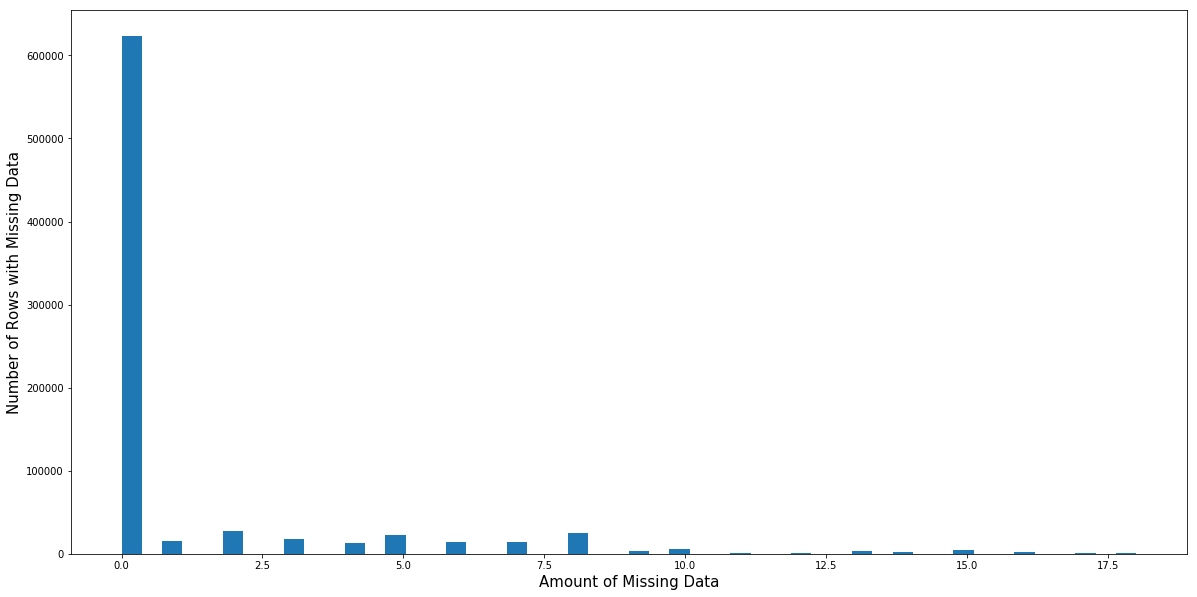

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
cleaned_azdias = clean_data(azdias)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
print(cleaned_azdias.shape)
cleaned_azdias.isnull().sum()[cleaned_azdias.isnull().sum()>0].sort_values(ascending=False)

(795897, 176)


KKK                     63049
REGIOTYP                63049
W_KEIT_KIND_HH          58634
LP_LEBENSPHASE_FEIN     49409
KBA05_GBZ               38027
KBA05_ANTG3             38027
KBA05_ANTG2             38027
KBA05_ANTG1             38027
MOBI_REGIO              38027
KBA05_ANTG4             38027
VERS_TYP                36232
HEALTH_TYP              36232
PJ_AVANTGARDE           28285
PJ_DECADE               28285
PLZ8_ANTG4              21212
PLZ8_BAUMAX             21212
PLZ8_ANTG2              21212
PLZ8_ANTG1              21212
PLZ8_HHZ                21212
PLZ8_GBZ                21212
PLZ8_ANTG3              21212
KBA13_ANZAHL_PKW        11008
ANZ_HAUSHALTE_AKTIV      6275
CI_LIFE_STAGE            4859
CI_WEALTH                4859
ONLINE_AFFINITAET        4623
RETOURTYP_BK_S           4623
ARBEIT                   4214
RELAT_AB                 4214
ORTSGR_KLS9              4114
ANZ_HH_TITEL             3675
ALTERSKATEGORIE_GROB     2758
BALLRAUM                  581
EWDICHTE  

In [51]:
pd.Series(cleaned_azdias.isnull().sum(axis=1)).describe()

count    795897.000000
mean          1.001199
std           2.557194
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
dtype: float64

In [52]:
# Number of missing values: number of columns with that number of missing values
Counter(cleaned_azdias.isnull().sum(axis=1).sort_values(ascending=False))

Counter({19: 4,
         18: 216,
         17: 387,
         16: 2507,
         15: 4425,
         14: 1974,
         13: 2854,
         12: 420,
         11: 588,
         10: 2291,
         9: 1482,
         8: 17835,
         7: 3458,
         6: 20024,
         5: 8641,
         4: 6455,
         3: 22531,
         2: 67083,
         1: 9513,
         0: 623209})

In [53]:
cols_with_nan = cleaned_azdias.isnull().sum()[cleaned_azdias.isnull().sum()>0].index
nan_feat_info = feat_info[feat_info['attribute'].isin(cols_with_nan)]
for index, row in nan_feat_info.iterrows():
    col = cleaned_azdias[row['attribute']]
    nan_feat_info.loc[index, 'unique'] = str(col.unique())
    nan_feat_info.loc[index, 'nunique'] = int(col.dropna().nunique())
nan_feat_info

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,attribute,information_level,type,missing_or_unknown,unique,nunique
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",[ 1. 3. 4. 2. nan],4.0
14,HEALTH_TYP,person,ordinal,"[-1,0]",[ 3. 2. 1. nan],3.0
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[ 21. 3. nan 32. 8. 2. 5. 10. 4. ...,40.0
23,RETOURTYP_BK_S,person,ordinal,[0],[ 1. 3. 2. 5. 4. nan],5.0
41,VERS_TYP,person,categorical,[-1],[ 2. 1. nan],2.0
48,W_KEIT_KIND_HH,household,ordinal,"[-1,0]",[ 3. nan 2. 6. 5. 4. 1.],6.0
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0],[ 11. 10. 1. 3. 5. 4. 6. ...,291.0
51,ANZ_HH_TITEL,building,numeric,[],[ 0. 1. 5. nan 2. 3. 7. 4. 6. ...,21.0
53,KONSUMNAEHE,building,ordinal,[],[ 1. 5. 4. 3. 2. 6. 7. nan],7.0
60,KBA05_ANTG1,microcell_rr3,ordinal,[-1],[ 0. 1. 4. 2. 3. nan],5.0


In [54]:
cleaned_azdias[cols_with_nan].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 795897 entries, 1 to 891220
Data columns (total 37 columns):
ALTERSKATEGORIE_GROB    793139 non-null float64
HEALTH_TYP              759665 non-null float64
LP_LEBENSPHASE_FEIN     746488 non-null float64
RETOURTYP_BK_S          791274 non-null float64
VERS_TYP                759665 non-null float64
W_KEIT_KIND_HH          737263 non-null float64
ANZ_HAUSHALTE_AKTIV     789622 non-null float64
ANZ_HH_TITEL            792222 non-null float64
KONSUMNAEHE             795837 non-null float64
KBA05_ANTG1             757870 non-null float64
KBA05_ANTG2             757870 non-null float64
KBA05_ANTG3             757870 non-null float64
KBA05_ANTG4             757870 non-null float64
KBA05_GBZ               757870 non-null float64
BALLRAUM                795316 non-null float64
EWDICHTE                795316 non-null float64
INNENSTADT              795316 non-null float64
GEBAEUDETYP_RASTER      795892 non-null float64
KKK                     7

In [55]:
imputer = Imputer(missing_values=np.nan, strategy='median')
azdias_filled = imputer.fit_transform(cleaned_azdias)

In [57]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(azdias_filled)
azdias_scaled = pd.DataFrame(scaled_features, columns=cleaned_azdias.columns)

In [58]:
print(azdias_scaled.shape)
azdias_scaled.head()

(795897, 176)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_AVANTGARDE,PJ_DECADE,CI_WEALTH,CI_LIFE_STAGE
0,-1.766625,0.958121,-1.494096,1.538377,-1.041212,1.466431,0.961678,1.337559,-0.530680,1.095483,...,-0.150225,-0.162744,-0.189749,-0.180023,-0.193029,-0.089752,-0.530680,1.173201,1.185840,-1.265639
1,0.200352,0.958121,-1.494096,0.865036,-1.767512,-0.570742,0.246673,1.337559,1.884375,1.095483,...,-0.150225,-0.162744,-0.189749,-0.180023,-0.193029,-0.089752,1.884375,1.173201,-0.867249,0.760816
2,1.183841,0.958121,0.683580,-0.481647,1.137687,-0.570742,-1.183335,-0.794462,-0.530680,-0.257863,...,-0.150225,-0.162744,-0.189749,-0.180023,-0.193029,-0.089752,-0.530680,-0.222916,-1.551612,-0.590154
3,0.200352,-1.043710,0.683580,0.191694,0.411387,-1.249799,0.246673,-0.794462,-0.530680,1.095483,...,-0.150225,-0.162744,-0.189749,-0.180023,-0.193029,-0.089752,-0.530680,-0.222916,0.501477,0.085331
4,-1.766625,0.958121,-0.042312,-1.154988,1.137687,-0.570742,-0.468331,1.337559,-0.530680,1.095483,...,-0.150225,-0.162744,-0.189749,-0.180023,-0.193029,-0.089752,-0.530680,-1.619034,1.185840,0.760816


### Discussion 2.1: Apply Feature Scaling
##### My decisions regarding feature scaling.
All the remaining features are missing 8% of its values or less. The remaining rows are missing on average 1 value with a deviation of 2.5 missing values. The maximum number of missing values per row is 19, around 10%.  
  
Given the few missing values, I have decided to fill in the missing values rather than removing them. I chose not to fill the missing values with the mode of each column as it would cause the data to skew towards the most common values and could potentially cause the clusters to clump together. I chose not to fill the missing values with mean as the mean tends to be sensitive to outliers in the columns, which would again skew the the data towards the outliers. That left filling the missing values with median, which could squash the dataset towards the center becuase medians tend to be more robust against outliers. But I felt that the median would have the most neutral influence on the dataset. 

Between the MinMaxScaler, which normalizes the variables between 0 to 1, and StandardScaler, which scales the variables with a mean of 1 and standard deviation of 1, I chose to Standard Scale. Standard Scalar is the recommended standardization for clustering and dimension reduction transformations as it ensures consistent clustering.   


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.
def do_pca(n_components,data):
    X = data
    pca = PCA(n_components,whiten=True,random_state=42)
    X_pca = pca.fit_transform(X)
    print(X_pca.shape)
    return pca, X_pca

In [60]:
pca, x_pca = do_pca(azdias_scaled.shape[1], azdias_scaled)

(795897, 176)


In [61]:
def scree_plot(pca):
    vals = pca.explained_variance_ratio_
    num_components=len(vals)
    ind = np.arange(num_components)

    plt.figure(figsize=(20,10))
    plt.grid(True)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=15)
    ax.set_ylabel("Variance Explained (%)", fontsize=15)
    plt.title('Explained Variance Per Principal Component', fontsize=15)
    

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


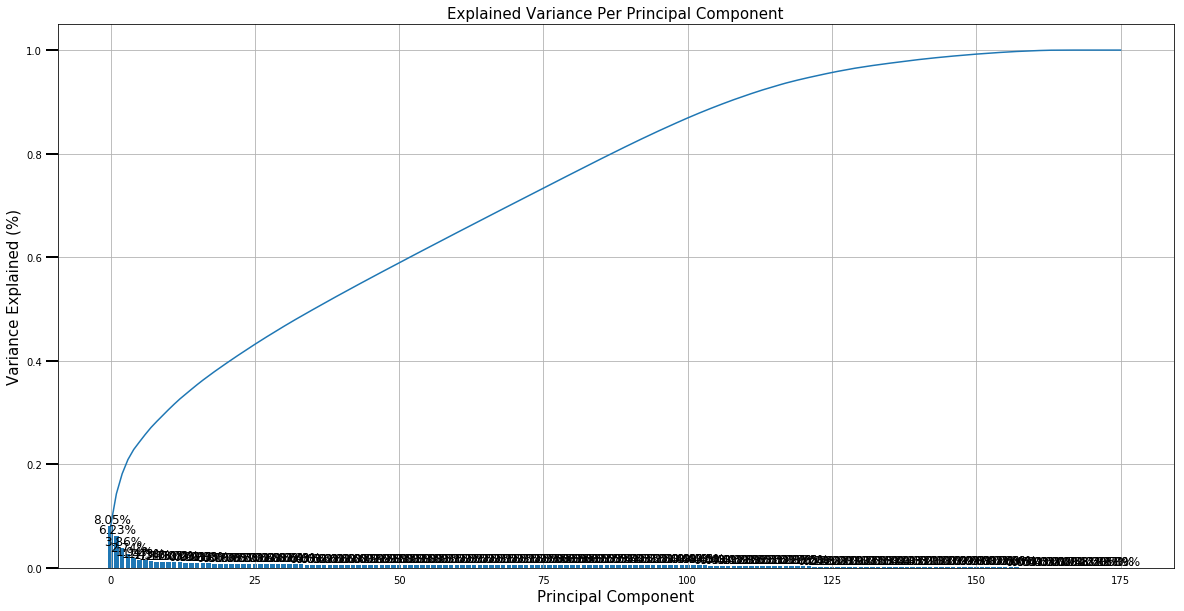

In [62]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [63]:
# Re-apply PCA to the data while selecting for number of components to retain.
nth_component = 25
pca, x_pca = do_pca(nth_component, azdias_scaled)

(795897, 25)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


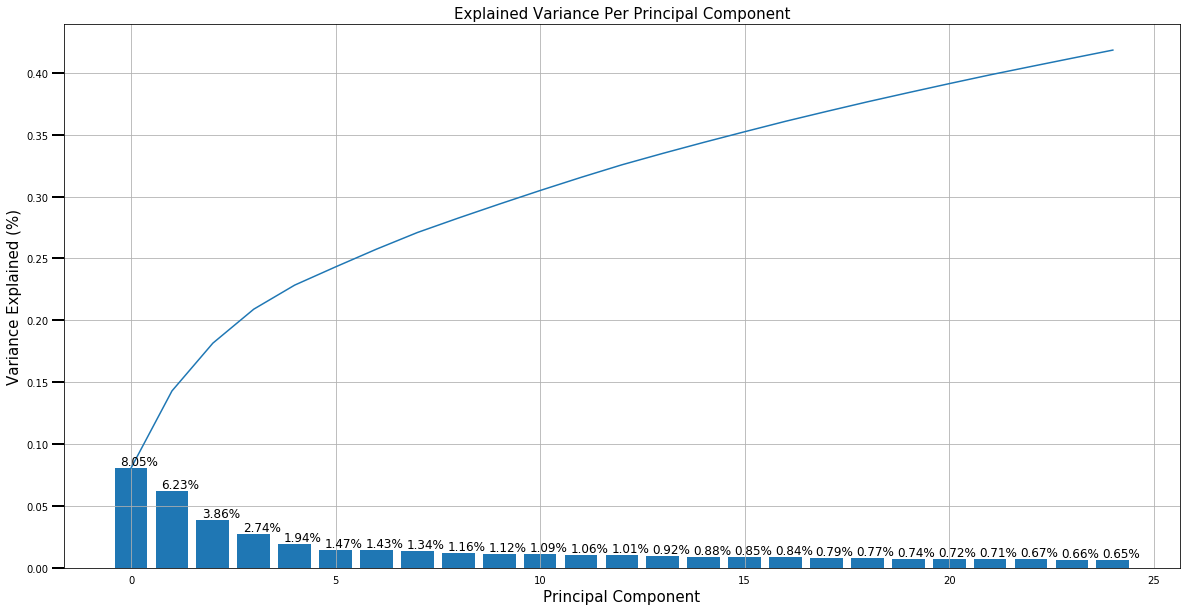

In [64]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction
##### My findings and decisions regarding dimensionality reduction. 
Based on the first scree plot above, visualizing the cumulative variance explained with each additional principal component, the rate of gained variance explanation appears to start to slow down at 2 points, just before 25 pricipal components where the cumulative variance explained is at 40%, and at 80 principal components where cumulative variance explained is about 75%. After 80 pricinipal components, the gained variance explained begins to level off. Between 25 and 80 principal components, there appears to be a steady increase in the variance explanation gained.  
  
##### How many principal components / transformed features are you retaining for the next step of the analysis?
I chose 25 principal components, with 42.4% cumulative variance explained, because any more additional pricipal components will increase the computational cost as we continue our analysis but the rate of increase in the variance explained declines.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def n_component_result(full_dataset, pca, n_component):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    return components.loc['Dimension {}'.format(n_component)].sort_values(ascending=False)

print(n_component_result(azdias_scaled, pca, 1))


PLZ8_ANTG3               0.1920
PLZ8_ANTG4               0.1870
HH_EINKOMMEN_SCORE       0.1851
CI_WEALTH                0.1838
PLZ8_BAUMAX              0.1832
ORTSGR_KLS9              0.1667
EWDICHTE                 0.1649
FINANZ_HAUSBAUER         0.1485
KBA05_ANTG4              0.1343
PLZ8_ANTG2               0.1313
FINANZ_SPARER            0.1259
LP_STATUS_FEIN_1.0       0.1229
LP_STATUS_FEIN_2.0       0.1203
FINANZTYP_1              0.1196
KBA05_ANTG3              0.1196
ARBEIT                   0.1193
ANZ_HAUSHALTE_AKTIV      0.1192
RELAT_AB                 0.1132
SEMIO_PFLICHT            0.0941
SEMIO_REL                0.0902
LP_FAMILIE_FEIN_1.0      0.0859
PJ_DECADE                0.0831
ZABEOTYP_5               0.0819
SEMIO_RAT                0.0781
GEBAEUDETYP_3.0          0.0723
SEMIO_TRADV              0.0702
CAMEO_DEU_2015_8A        0.0638
SEMIO_MAT                0.0621
FINANZ_UNAUFFAELLIGER    0.0617
GFK_URLAUBERTYP_12.0     0.0613
                          ...  
CJT_GESA

In [66]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(n_component_result(azdias_scaled, pca, 2))

ALTERSKATEGORIE_GROB     0.2313
FINANZ_VORSORGER         0.2168
ZABEOTYP_3               0.2002
SEMIO_ERL                0.1811
SEMIO_LUST               0.1632
RETOURTYP_BK_S           0.1563
W_KEIT_KIND_HH           0.1237
CJT_GESAMTTYP_2.0        0.1060
LP_STATUS_FEIN_1.0       0.1017
FINANZTYP_5              0.0999
FINANZ_HAUSBAUER         0.0936
FINANZTYP_2              0.0881
FINANZ_MINIMALIST        0.0798
PLZ8_ANTG3               0.0760
EWDICHTE                 0.0756
SEMIO_KRIT               0.0751
ORTSGR_KLS9              0.0749
SHOPPER_TYP_3.0          0.0745
PLZ8_ANTG4               0.0725
PLZ8_BAUMAX              0.0703
CJT_GESAMTTYP_1.0        0.0699
FINANZTYP_6              0.0666
CI_WEALTH                0.0643
NATIONALITAET_KZ_1.0     0.0632
SEMIO_KAEM               0.0627
GFK_URLAUBERTYP_4.0      0.0601
KBA05_ANTG4              0.0598
LP_FAMILIE_FEIN_1.0      0.0569
ARBEIT                   0.0565
WOHNDAUER_2008           0.0541
                          ...  
PLZ8_GBZ

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print(n_component_result(azdias_scaled, pca, 3))

SEMIO_VERT               0.3229
SEMIO_FAM                0.2599
SEMIO_SOZ                0.2576
SEMIO_KULT               0.2505
FINANZTYP_5              0.1366
FINANZ_MINIMALIST        0.1347
SHOPPER_TYP_0.0          0.1244
ZABEOTYP_1               0.1176
SEMIO_REL                0.1094
SEMIO_MAT                0.0866
RETOURTYP_BK_S           0.0768
PJ_AVANTGARDE            0.0714
GREEN_AVANTGARDE         0.0714
W_KEIT_KIND_HH           0.0644
ORTSGR_KLS9              0.0584
EWDICHTE                 0.0579
SHOPPER_TYP_1.0          0.0548
FINANZ_VORSORGER         0.0521
LP_STATUS_FEIN_3.0       0.0496
ZABEOTYP_6               0.0495
PLZ8_BAUMAX              0.0475
LP_STATUS_FEIN_10.0      0.0469
PLZ8_ANTG4               0.0448
PLZ8_ANTG3               0.0442
LP_STATUS_FEIN_1.0       0.0417
PLZ8_ANTG2               0.0322
RELAT_AB                 0.0317
ARBEIT                   0.0306
GFK_URLAUBERTYP_4.0      0.0285
NATIONALITAET_KZ_2.0     0.0278
                          ...  
CJT_GESA

### Discussion 2.3: Interpret Principal Components
##### My observations from detailed investigation of the first few principal components generated.  Can we interpret positive and negative values from them in a meaningful way?  
###### First Principal Component: 
The top 3 positive components are 
   * 'PLZ8_ANTG3', Number of 6-10 family houses in the PLZ8 region
   * 'PLZ8_ANTG4', Number of 10+ family houses in the PLZ8 region 
   * 'HH_EINKOMMEN_SCORE', Estimated household net income
  
The top 3 negative components are 
   * 'MOBI_REGIO', Movement patterns
   * 'FINANZ_MINIMALIST', Financial typology - low financial interest
   * 'KBA05_ANTG1', Number of 1-2 family houses in the microcell     
  
The first component covers the topic of households, their size, their finances, etc. 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE', and 'KBA05_ANTG1' are explicitly about households. 'FINANZ_MINIMALIST' is related to the estimated household net income, because the subjects of this dataset are generally adults and probably the breadwinners of their households. Their finaicial interest likely correlates with the estimated household net income. 'MOBI_REGIO' has a very vague description in the Data Dictionary, a region feature for 'Movement patterns'. Given that it grouped with other household information, 'MOBI_REGIO' must be related to the movement patterns of a household. 

###### Second Principal Component: 
The top 3 positive components are 
   * 'ALTERSKATEGORIE_GROB', Estimated age based on given name analysis
   * 'FINANZ_VORSORGER', Financial typology, be prepared
   * 'ZABEOTYP_3', Energy consumption typology
   
The top 3 negative components are 
   * 'FINANZ_UNAUFFAELLIGER', Financial typology, inconspicuous
   * 'FINANZ_SPARER', Financial typology, money-saver
   * 'PJ_DECADE', generation by decade
  
The second component covers individual-level consumer and financial information. 'FINANZ_VORSORGER', 'FINANZ_UNAUFFAELLIGER', and 'FINANZ_SPARER' are explicitly about financial style of the individuals. 'ALTERSKATEGORIE_GROB' and 'PJ_DECADE' are about the ages of the subjects of this dataset. Age is related to financial habits and styles, i.e. a younger individual, has likely worked less, and therefore has less money saved up, but an olders individual, has likely worked longer, and therefore has more money saved up. 'ZABEOTYP_3' describes energy consumption, which is likely a refection of an individual's financial habits and styles. 

###### Third Principal Component: 
The top 3 positive components are 
   * 'SEMIO_VERT', Personality typology, dreamful
   * 'SEMIO_FAM', Personality typology, family-minded
   * 'SEMIO_SOZ', Personality typology, socially-minded
   
The top 3 negative components are 
   * 'SEMIO_DOM', Personality typology, dominant-minded 
   * 'SEMIO_KAEM', Personality typology, combative attitude
   * 'ANREDE_KZ', Gender
  
The third component covers individual-level personality types. 'SEMIO_VERT', 'SEMIO_FAM', 'SEMIO_SOZ', 'SEMIO_DOM', and 'SEMIO_KAEM' are explicitly about personality typology. 'ANREDE_KZ' describes an individual's gender, which is likely related in some way to the personality typology.   

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    return score

    # run k-means clustering on the data and...
def elbow_curve(data, numbers_of_clusters):
    scores = {}
    for n_cluster in numbers_of_clusters:
        scores[n_cluster] = (get_kmeans_score(data, n_cluster))
        print('{} clusters processed'.format(n_cluster))
    return scores
    # compute the average within-cluster distances.
reduced_azdias = x_pca

In [69]:
numbers_of_clusters = list(range(1, 25, 3))
within_cluster_distances = elbow_curve(reduced_azdias, numbers_of_clusters)    

1 clusters processed
4 clusters processed
7 clusters processed
10 clusters processed
13 clusters processed
16 clusters processed
19 clusters processed
22 clusters processed


In [70]:
for k, v in within_cluster_distances.items():
    print('For {} clusters, average within-cluster distance = {}'.format(k, v))

For 1 clusters, average within-cluster distance = 19897400.000000004
For 4 clusters, average within-cluster distance = 18135294.280789744
For 7 clusters, average within-cluster distance = 16845009.669710025
For 10 clusters, average within-cluster distance = 15936083.75130372
For 13 clusters, average within-cluster distance = 15331178.519713044
For 16 clusters, average within-cluster distance = 14856701.017767211
For 19 clusters, average within-cluster distance = 14436388.67530539
For 22 clusters, average within-cluster distance = 14159610.251493635


Text(0.5,1,'SSE vs. K')

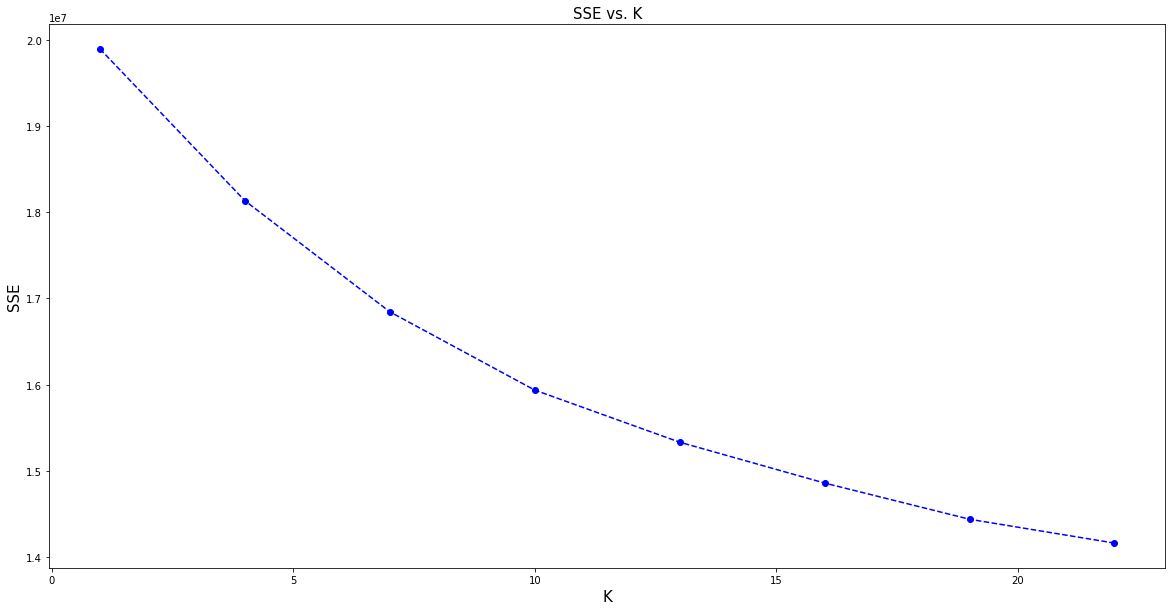

In [71]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = [v for k, v in within_cluster_distances.items()] 

plt.figure(figsize=(20,10))
plt.plot(numbers_of_clusters, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.title('SSE vs. K', fontsize=15)

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

elbow = 8
kmeans = KMeans(n_clusters=elbow)
azdias_clusters = kmeans.fit(reduced_azdias)
azdias_predictions = kmeans.predict(reduced_azdias)

In [73]:
for cluster in list(range(elbow)):
    print('Cluster {}: {}'.format(cluster, Counter(azdias_predictions)[cluster]))

Cluster 0: 92592
Cluster 1: 112869
Cluster 2: 147448
Cluster 3: 73804
Cluster 4: 127089
Cluster 5: 59469
Cluster 6: 179247
Cluster 7: 3379


### Discussion 3.1: Apply Clustering to General Population
##### My findings and decisions regarding clustering. 
The plot above visualizes the sum of sqaured errors, the average distance of all the data points from the center of their corresponding cluster, for an increasing number of clusters. After investigating between 1 and 25 clusters, in steps of 3, 5 to 10 clusters appear to be at the "elbow".  Less than 5 clusters appear to be too much error. More than 10 clusters would be computationally expensive with each additional cluster but not worth the minimal decrease in error. 

##### Into how many clusters have you decided to segment the population?
I chose to segment the population into 8 clusters as a compromise between 5 clusters, which might still be too much error, and 10 clusters, which might still be too computationally expensive for the decrease in error. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

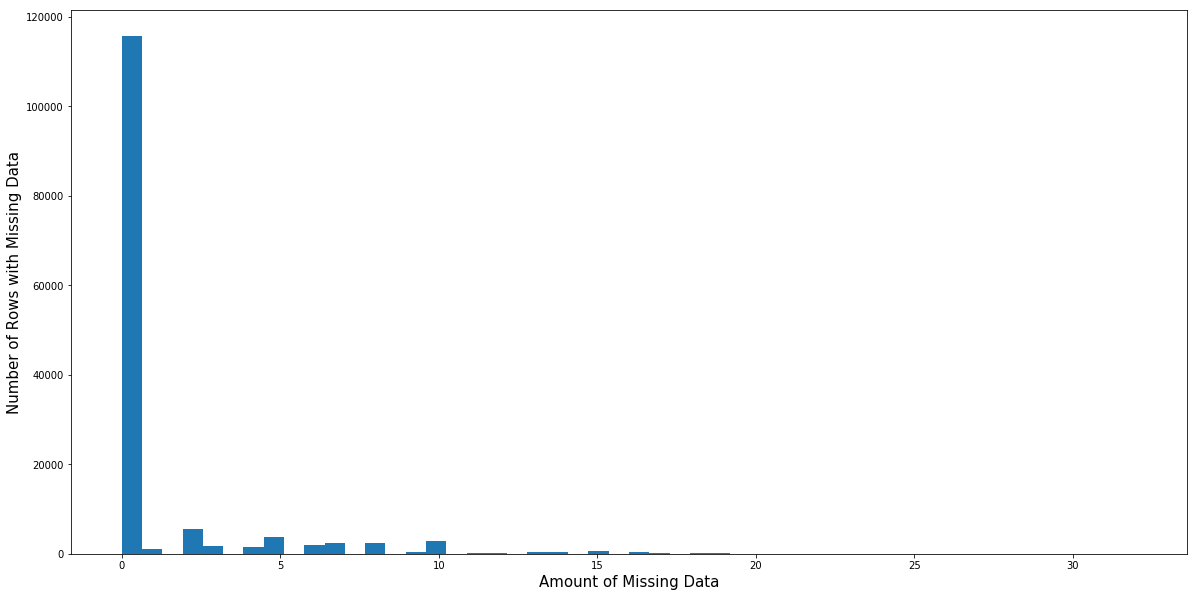

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3924: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(141771, 175)


In [74]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')
cleaned_customers = clean_data(customers)
print(cleaned_customers.shape)

In [75]:
set(azdias_scaled.columns)-set(cleaned_customers.columns)

{'GEBAEUDETYP_5.0'}

In [76]:
cleaned_customers['GEBAEUDETYP_5.0'] = 0
print(cleaned_customers.shape)

(141771, 176)


In [77]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_filled = imputer.transform(cleaned_customers)

scaled_customers = scaler.transform(customers_filled)

reduced_customers = pca.transform(scaled_customers)

customer_predictions = kmeans.predict(reduced_customers)

In [78]:
for cluster in list(range(elbow)):
    print('Cluster {}: {}'.format(cluster, Counter(customer_predictions)[cluster]))

Cluster 0: 25
Cluster 1: 140465
Cluster 2: 906
Cluster 3: 1
Cluster 4: 2
Cluster 5: 18
Cluster 6: 340
Cluster 7: 14


In [84]:
customer_clusters = pd.DataFrame(customers_filled, columns=cleaned_customers.columns)
customer_clusters['predictions'] = customer_predictions
print(customer_clusters.shape)
customer_clusters.head()

(141771, 177)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PJ_AVANTGARDE,PJ_DECADE,CI_WEALTH,CI_LIFE_STAGE,GEBAEUDETYP_5.0,predictions
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1950.0,1.0,3.0,0.0,1
1,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0.0,0.0,0.0,0.0,1.0,1950.0,3.0,4.0,0.0,1
2,4.0,1.0,5.0,1.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1940.0,2.0,4.0,0.0,1
3,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1970.0,4.0,1.0,0.0,1
4,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,1950.0,3.0,4.0,0.0,1


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [112]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
azdias_value_counts = pd.Series(azdias_predictions).value_counts(normalize=True)
customer_value_counts = pd.Series(customer_predictions).value_counts(normalize=True)

general_proportion = pd.DataFrame()
general_proportion['proportion'] = azdias_value_counts
general_proportion['label'] = azdias_value_counts.index
general_proportion['source'] = 'population'

customer_proportion = pd.DataFrame()
customer_proportion['proportion'] = customer_value_counts
customer_proportion['label'] = customer_value_counts.index
customer_proportion['source'] = 'customers'

proportions = pd.concat([general_proportion, customer_proportion])

Text(0,0.5,'Proportion')

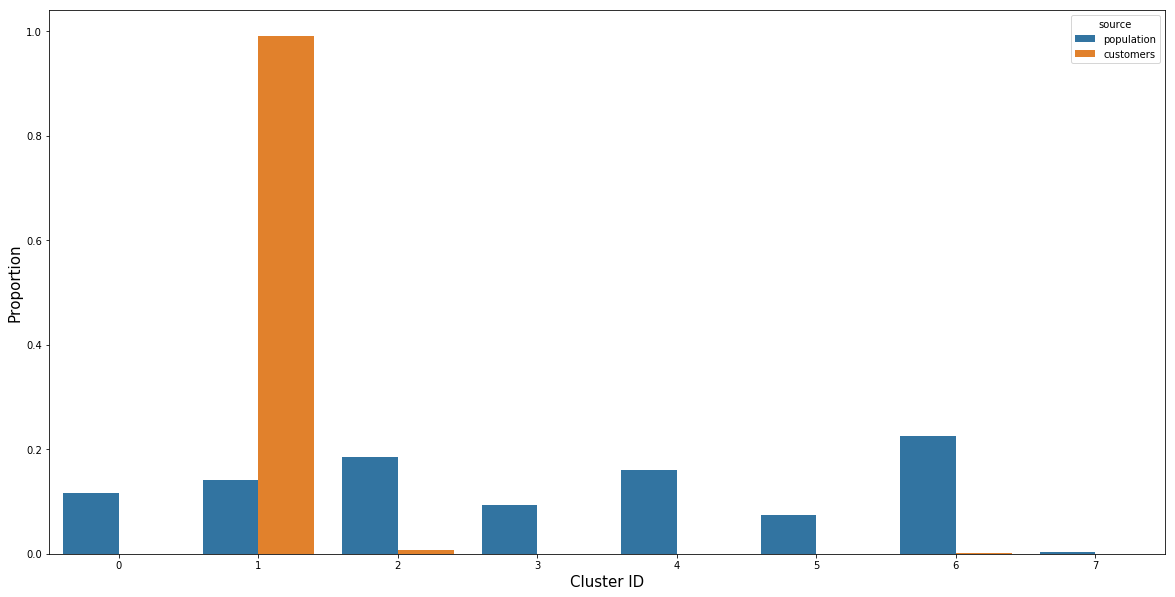

In [113]:
fig = plt.figure(figsize = (20,10))
ax = sns.barplot(x='label', y="proportion", hue='source', data= proportions)
ax.set_xlabel("Cluster ID", fontsize=15)
ax.set_ylabel("Proportion", fontsize=15)

In [114]:
difference_proportion = customer_proportion.sort_values(['label'])['proportion'] - general_proportion.sort_values(['label'])['proportion']
print('Overrepresented')
print(difference_proportion.sort_values(ascending=False))
print('Underrepresented')

Overrepresented
1    0.848974
7   -0.004147
5   -0.074593
3   -0.092724
0   -0.116160
4   -0.159666
2   -0.178870
6   -0.222816
Name: proportion, dtype: float64
Underrepresented


In [115]:
proportion_rank = list(difference_proportion.sort_values(ascending=False).index)

In [116]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
overrepped_cluster = customer_clusters[customer_clusters['predictions']==proportion_rank[0]]
overrepped_cluster.shape

(140465, 177)

In [132]:
for col in sorted(overrepped_cluster.columns):
    mean = float(overrepped_cluster[col].mean())
    print(col, '\t', mean)

ALTERSKATEGORIE_GROB 	 3.4879934503257037
ANREDE_KZ 	 1.3288078880860001
ANZ_HAUSHALTE_AKTIV 	 4.967678781191044
ANZ_HH_TITEL 	 0.06600220695546934
ANZ_PERSONEN 	 2.276645427686612
ANZ_TITEL 	 0.02046773217527498
ARBEIT 	 2.824027337770975
BALLRAUM 	 4.301114156551454
CAMEO_DEU_2015_1A 	 0.029715587512903572
CAMEO_DEU_2015_1B 	 0.008158616025344392
CAMEO_DEU_2015_1C 	 0.015648026198697186
CAMEO_DEU_2015_1D 	 0.041768412059943756
CAMEO_DEU_2015_1E 	 0.023721211689744778
CAMEO_DEU_2015_2A 	 0.026262770085074574
CAMEO_DEU_2015_2B 	 0.024653828355818176
CAMEO_DEU_2015_2C 	 0.035966254938952766
CAMEO_DEU_2015_2D 	 0.07937920478410992
CAMEO_DEU_2015_3A 	 0.013312924927917988
CAMEO_DEU_2015_3B 	 0.012522692485672587
CAMEO_DEU_2015_3C 	 0.046951197807282956
CAMEO_DEU_2015_3D 	 0.057224219556473145
CAMEO_DEU_2015_4A 	 0.05313779233260955
CAMEO_DEU_2015_4B 	 0.014829316911686185
CAMEO_DEU_2015_4C 	 0.06411561598974834
CAMEO_DEU_2015_4D 	 0.015021535613853986
CAMEO_DEU_2015_4E 	 0.009098351902609

In [119]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepped_cluster = customer_clusters[customer_clusters['predictions']==proportion_rank[-1]]
underrepped_cluster.shape

(340, 177)

In [133]:
for col in sorted(underrepped_cluster.columns):
    mean = float(underrepped_cluster[col].mean())
    print(col, '\t', mean)

ALTERSKATEGORIE_GROB 	 3.2794117647058822
ANREDE_KZ 	 1.6529411764705881
ANZ_HAUSHALTE_AKTIV 	 15.535294117647059
ANZ_HH_TITEL 	 0.061764705882352944
ANZ_PERSONEN 	 1.2323529411764707
ANZ_TITEL 	 0.0
ARBEIT 	 3.1029411764705883
BALLRAUM 	 4.15
CAMEO_DEU_2015_1A 	 0.014705882352941176
CAMEO_DEU_2015_1B 	 0.0029411764705882353
CAMEO_DEU_2015_1C 	 0.0
CAMEO_DEU_2015_1D 	 0.0058823529411764705
CAMEO_DEU_2015_1E 	 0.0029411764705882353
CAMEO_DEU_2015_2A 	 0.0029411764705882353
CAMEO_DEU_2015_2B 	 0.0
CAMEO_DEU_2015_2C 	 0.0
CAMEO_DEU_2015_2D 	 0.020588235294117647
CAMEO_DEU_2015_3A 	 0.0029411764705882353
CAMEO_DEU_2015_3B 	 0.0
CAMEO_DEU_2015_3C 	 0.011764705882352941
CAMEO_DEU_2015_3D 	 0.01764705882352941
CAMEO_DEU_2015_4A 	 0.011764705882352941
CAMEO_DEU_2015_4B 	 0.0
CAMEO_DEU_2015_4C 	 0.008823529411764706
CAMEO_DEU_2015_4D 	 0.008823529411764706
CAMEO_DEU_2015_4E 	 0.0058823529411764705
CAMEO_DEU_2015_5A 	 0.008823529411764706
CAMEO_DEU_2015_5B 	 0.0
CAMEO_DEU_2015_5C 	 0.00294117647

In [131]:
# similarities
print('COLUMN \t OVER \t UNDER')
for col in sorted(underrepped_cluster.columns):
    over_mode = float(overrepped_cluster[col].mode())
    under_mode = float(underrepped_cluster[col].mode())
    if over_mode == under_mode:
        print(col,'\t', over_mode, '\t', under_mode)

COLUMN 	 OVER 	 UNDER
ALTERSKATEGORIE_GROB 	 4.0 	 4.0
ANZ_HH_TITEL 	 0.0 	 0.0
ANZ_TITEL 	 0.0 	 0.0
ARBEIT 	 3.0 	 3.0
BALLRAUM 	 6.0 	 6.0
CAMEO_DEU_2015_1A 	 0.0 	 0.0
CAMEO_DEU_2015_1B 	 0.0 	 0.0
CAMEO_DEU_2015_1C 	 0.0 	 0.0
CAMEO_DEU_2015_1D 	 0.0 	 0.0
CAMEO_DEU_2015_1E 	 0.0 	 0.0
CAMEO_DEU_2015_2A 	 0.0 	 0.0
CAMEO_DEU_2015_2B 	 0.0 	 0.0
CAMEO_DEU_2015_2C 	 0.0 	 0.0
CAMEO_DEU_2015_2D 	 0.0 	 0.0
CAMEO_DEU_2015_3A 	 0.0 	 0.0
CAMEO_DEU_2015_3B 	 0.0 	 0.0
CAMEO_DEU_2015_3C 	 0.0 	 0.0
CAMEO_DEU_2015_3D 	 0.0 	 0.0
CAMEO_DEU_2015_4A 	 0.0 	 0.0
CAMEO_DEU_2015_4B 	 0.0 	 0.0
CAMEO_DEU_2015_4C 	 0.0 	 0.0
CAMEO_DEU_2015_4D 	 0.0 	 0.0
CAMEO_DEU_2015_4E 	 0.0 	 0.0
CAMEO_DEU_2015_5A 	 0.0 	 0.0
CAMEO_DEU_2015_5B 	 0.0 	 0.0
CAMEO_DEU_2015_5C 	 0.0 	 0.0
CAMEO_DEU_2015_5D 	 0.0 	 0.0
CAMEO_DEU_2015_5E 	 0.0 	 0.0
CAMEO_DEU_2015_5F 	 0.0 	 0.0
CAMEO_DEU_2015_6A 	 0.0 	 0.0
CAMEO_DEU_2015_6B 	 0.0 	 0.0
CAMEO_DEU_2015_6C 	 0.0 	 0.0
CAMEO_DEU_2015_6D 	 0.0 	 0.0
CAMEO_DEU_2015_6E 

In [130]:
# differences
print('COLUMN \t OVER \t UNDER')
for col in sorted(underrepped_cluster.columns):
    over_mode = float(overrepped_cluster[col].mode())
    under_mode = float(underrepped_cluster[col].mode())
    if over_mode != under_mode:
        print(col,'\t', over_mode, '\t', under_mode)

COLUMN 	 OVER 	 UNDER
ANREDE_KZ 	 1.0 	 2.0
ANZ_HAUSHALTE_AKTIV 	 1.0 	 8.0
ANZ_PERSONEN 	 2.0 	 1.0
CI_LIFE_STAGE 	 4.0 	 5.0
CI_WEALTH 	 2.0 	 5.0
EWDICHTE 	 5.0 	 6.0
FINANZ_HAUSBAUER 	 2.0 	 5.0
FINANZ_MINIMALIST 	 5.0 	 3.0
FINANZ_UNAUFFAELLIGER 	 1.0 	 2.0
GREEN_AVANTGARDE 	 1.0 	 0.0
HH_EINKOMMEN_SCORE 	 1.0 	 6.0
INNENSTADT 	 5.0 	 4.0
KBA05_ANTG1 	 3.0 	 0.0
KBA05_ANTG2 	 1.0 	 0.0
KBA05_GBZ 	 4.0 	 1.0
KBA13_ANZAHL_PKW 	 1400.0 	 549.0
KONSUMNAEHE 	 3.0 	 1.0
LP_FAMILIE_FEIN_1.0 	 0.0 	 1.0
MOBI_REGIO 	 5.0 	 1.0
ONLINE_AFFINITAET 	 4.0 	 1.0
PJ_AVANTGARDE 	 1.0 	 0.0
PJ_DECADE 	 1950.0 	 0.0
PLZ8_ANTG2 	 3.0 	 4.0
PLZ8_ANTG3 	 1.0 	 2.0
PLZ8_ANTG4 	 0.0 	 1.0
PLZ8_HHZ 	 3.0 	 4.0
REGIOTYP 	 5.0 	 3.0
RELAT_AB 	 3.0 	 5.0
SEMIO_DOM 	 3.0 	 5.0
SEMIO_KAEM 	 3.0 	 6.0
SEMIO_KULT 	 4.0 	 1.0
SEMIO_MAT 	 1.0 	 4.0
SEMIO_REL 	 4.0 	 2.0
SEMIO_SOZ 	 6.0 	 5.0
SEMIO_TRADV 	 4.0 	 3.0
SEMIO_VERT 	 7.0 	 4.0
ZABEOTYP_3 	 0.0 	 1.0
predictions 	 1.0 	 6.0


### Discussion 3.3: Compare Customer Data to Demographics Data
##### My findings and conclusions from the clustering analysis. 
After applying the models, trained on the general population dataset, to customer dataset, the customer data segmented into the 8 clusters as such:   
25 in Cluster 0, 140465 in Cluster 1, 906 in Cluster 2, 1 in Cluster 3, 2 in Cluster 4, 18 in Cluster 5, 340 in Cluster 6, 14 in Cluster 7.   
Compared to the general population which segmented into 8 clusters as such:    
92592 in Cluster 0, 112869 in Cluster 1, 147448 in Cluster 2, 73804 in Cluster3, 127089 in Cluster 4, 59469 in Cluster 5, 179247 in Cluster 6, and 3379 in Cluster 7.   
  
There is a higher proportion of persons in Cluster 1 for the customer data compared to the general population data, which suggests that individuals with similar demographics as those in Cluster 4 would be the recommended target audience for the company.  In contrast, all the other clusters have significantly lower proprortions of persons from the customer data than the general population, which suggests that individuals with similar demographics as the those in the other clusters would be outside of the target audience for the company. In addition, Cluster 6 is especially underrepresented in the custumer data. It contains 340 observations, which is much greater than Clusters 0, 3, 4, 5, and 7. But with the general population data, Cluster 6 was the largest cluster. 
  
##### Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?
For cluster 1 and 6, I looked at the mode of each feature to see most represented demographics in each cluster. Upon first glance, the members of cluster 1 and 6 looked quite similar. Both clusters showed a large representation of single older, 46-60 year old individuals, unlikley to have children in the household. These indivudals are more rational and critically minded rather than event oriented or sensual minded. They are finacially conservative tending to invest and save their money but top earners. They reside in West Germany in residiential regions comprised mainly of 1-2 family homes.  After a closer look, I founded the following differences: 
  
###### Segment of the population that is relatively popular with the mail-order company.
Cluster 1 is the segment most popular with the mail order company. The individuals in this cluster are predominately male, a member of a properspous household and a mature couple. He is likely a homeowner with a high net income but living in a lower middle class neighborhood, which is aligned with his very high inconspicous finacial nature despite his very high financial interest. He is also highly materialistic with a high online affinity, while having a low socially minded or dreamful affinity.   
  
###### Segment of the population that is relatively unpopular with the company.
Cluster 6 is relatively unpopular with the company given how large a segment of the general population this cluster is. The individuals in this cluster are predominately female, with a high affinity for culture and religion. While she may live in an upper middle class neighborhood, she is very unlikely to be a homeowner, more likley to be living alone in a very low income household in an appartment complex. She has average financial interest while still being highly inconspicuous.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.